# <font style="color:blue">Binary Classification using a Perceptron</font>

We have seen the building blocks of a Neural Network. Before we start going into the details of neural networks, we will illustrate what a single neuron is capable of! Specifically, we will solve a Binary Classification problem ( with the same linearly separable data shown in the earlier lecture ) using a single Neuron.

The insteresting part is that we will implement all the building blocks from scratch so that you understand all the nuts and bolts of a Neuron and Neural Networks(by extension).

## <font style="color:rgb(8,133,37)">Problem statement</font>

We have two sets of data points generated with different mean and variance. The task is to train a classifier which is able to distinguish between the two classes. In other words, We have to find a hyperplane that separates the two sets of data. 

We have chosen the two-dimensional data as shown below, so we have to learn a line that separates these two sets of points. We will see in this notebook that by training the perceptron, we are trying to learn the parameters of the network which is same as estimating the parameters of the line separating the classes (also known as the **decision boundary**)

<img src="https://www.learnopencv.com/wp-content/uploads/2020/01/c3_w2_problem_statement.png" width=500>

# <font style="color:blue">1. Training Pipeline</font>
Given below is the training pipeline which consists of the Neuron and the weight update loop using the gradients. We have already learnt about neurons, activation functions, gradients and gradient descent weight update process in the previous sections. It's now time to put them all together and train a Binary Classifier.

<img src="https://www.learnopencv.com/wp-content/uploads/2020/01/c3_w2_single_neuron_train_arch.jpg" width=1000>

Let us understand the above pipeline in more details

## <font style="color:green">The Neuron</font>
The first part is the **`Neuron`** itself. The neuron has the following architecture:

1. Two `inputs` : $X = [x_1, x_2]$
1. Two `weights` : $W = [w_1, w_2]$
1. A `bias` Term : $B = b$
1. A `summation` which performs a weighted addition of the inputs. **The weights are learnable parameters**. Let's call it z for the time-being.

$$w_1x_1 + w_2x_2 + b = z(say)$$

5. A `sigmoid activation` function at the output of the neuron. Mathematically, it is given as

$$
\sigma(z) = \frac{1}{1 + e^{-z}} = \frac{1}{1 + e^{-(w_1x_1 + w_2x_2 + b)}} = y'(say)
$$

## <font style="color:green">Loss Function</font>
$y'$ gives the predicted output for a given input. Since this is the output of a sigmoid, it can also be thought of as a probability measure of class 1 or in other words, it gives the likelihood of class 1. We compare y' with the actual output ( also called thr ground_truth ) and compute a loss function. The loss function used for binary classification is the **`Binary Cross Entropy loss function`**. We will discuss about this in the next section. Mathematically, it is given as:

$$
J(y') = -y\log(y') - (1-y)\log(1-y')
$$

## <font style="color:green">Backpropagation</font>
The final part is the Weight update where we use **`Backpropagation`** to compute gradients and update the weights.


**Compute Gradients**

We need to compute the gradients of the loss function with respect to the weights and biases. 

$$
\frac{\partial J}{\partial W}, \frac{\partial J}{\partial B}
$$

**Chain Rule**

Since we cannot compute the gradients directly, we can use the chain rule described in the last section on Backpropagation. Applying chain rule, we get the following:

\begin{align}
\frac{\partial J}{\partial w_1} &= \frac{\partial J}{\partial y'}.\frac{\partial y'}{\partial z}. \frac{\partial z}{\partial w_1}  \\
\frac{\partial J}{\partial w_2} &= \frac{\partial J}{\partial y'}.\frac{\partial y'}{\partial z}. \frac{\partial z}{\partial w_2}  \\
\frac{\partial J}{\partial b} &= \frac{\partial J}{\partial y'}.\frac{\partial y'}{\partial z}. \frac{\partial z}{\partial b}  \\
\end{align}

**NOTE**: We can calculate the above derivatives separately and multiply them to get the required gradient.

**Weight Update**

The final step is to update the weights using the calculated gradients. This is done using the following equations.

$$
W \leftarrow W - \gamma \frac{\partial J}{\partial W}, \
B \leftarrow B - \gamma \frac{\partial J}{\partial B}
$$

In [3]:

%matplotlib inline

In [ ]:
import matplotlib.pyplot as plt  # one of the best graphics library for python
import matplotlib.animation as animation
plt.style.use('ggplot')


In [2]:
import torch
import numpy as np
import random

In [4]:
plt.rcParams["figure.figsize"] = (8, 8)

**Reproducibility first - let's fix all the random numbers generators to obtain reproducible results.**

In [5]:
seed = 3
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# <font style="color:blue">2. Create Data points</font>

We will create random data using a gaussian distribution. The data is similar to the one discussed in the lecture. This will be used for illustration

In [6]:
num_data_points = 500
class_zero_points = torch.empty(num_data_points, 2).normal_(mean=2,std=0.5)
class_one_points = torch.empty(num_data_points, 2).normal_(mean=4,std=0.7)

Text(0, 0.5, 'x2')

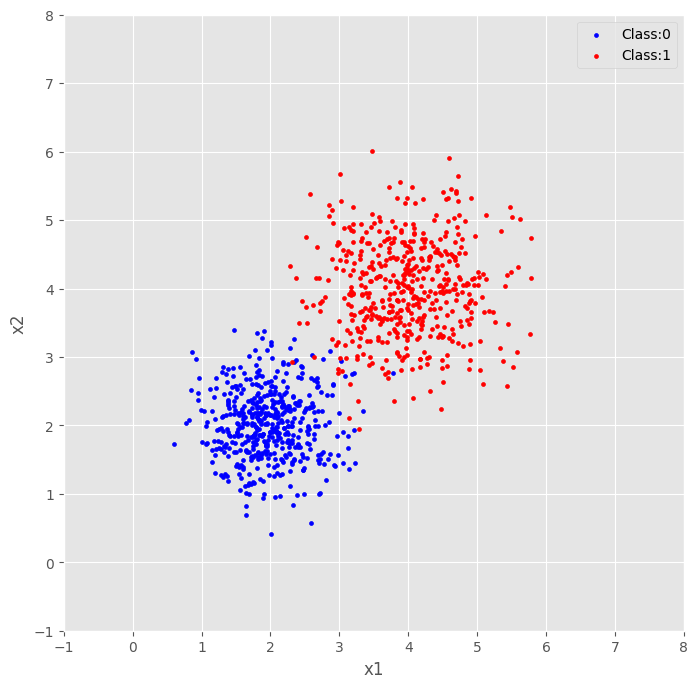

In [7]:
plt.scatter(class_zero_points[:,0], class_zero_points[:,1], s=8, color='b', label='Class:0')
plt.scatter(class_one_points[:,0], class_one_points[:,1], s=8, color='r', label='Class:1')
plt.legend()
plt.xlim([-1, 8])
plt.ylim([-1, 8])
plt.xlabel('x1')
plt.ylabel('x2')

# <font style="color:blue">3. Prepare Data</font>

We prepare the data so that it contains the data points from both classes.

In [13]:
label_zero = torch.zeros_like(class_zero_points[:,0], dtype=int)
label_one = torch.ones_like(class_one_points[:,0], dtype=int)

label = torch.cat([label_zero, label_one])
data_points = torch.cat([class_zero_points, class_one_points], dim=0)

print('Data points size: {}'.format(data_points.size()))
print('Label size: {}'.format(label.size()))


Data points size: torch.Size([1000, 2])
Label size: torch.Size([1000])


# <font style="color:blue">4. Implementing the Perceptron</font>
This is the neuron which is simply calculating the weighted sum of the inputs. It is given by:

$$
WX + B = w_1x_1 + w_2x_2 + b = z \text{  (let's)}
$$

Let's calculate the derivative of $z$ w.r.t the weights and bias.

**Derivative of $WX + B$  w.r.t its input $W$ and $B$:**

$$
\begin{align}
\frac{\partial z}{\partial w_1} &= x_1  \\
\frac{\partial z}{\partial w_2} &= x_2  \\
\frac{\partial z}{\partial b} &= 1 
\end{align}
$$

Let's define the perceptron and its derivative.

In [14]:
# Neuron: WX + B
def wx_plus_b(W, X, B):
    
    return torch.matmul(X, W) + B

# Derivative of WX + B w.r.t its input W and B
def grad_wx_plus_b(X):
    batch_size = X.size(0)
    g_w = X
    g_b = torch.ones(batch_size)
    
    return g_w, g_b


# <font style="color:blue">5. Why Sigmoid Activation?</font>
The Sigmoid function is given by:

$$
y' = \sigma(z) = \frac{1}{1 + e^{-z}}
$$
Let's plot the curve of a sigmoid function and see

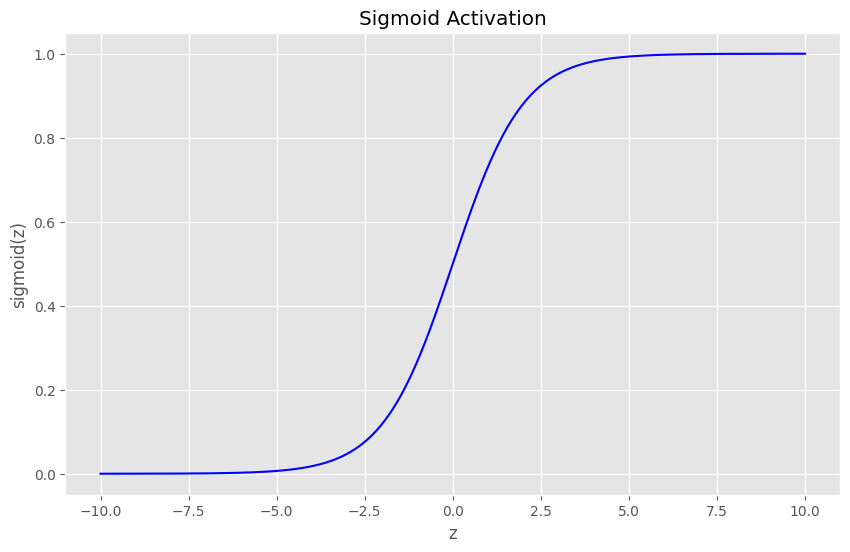

In [15]:
# Plot sigmoid
plt.rcParams["figure.figsize"] = (10, 6)
z = torch.linspace(-10, 10, 1000)
y = torch.sigmoid(z)

plt.figure
plt.plot(z, y, color='b')
plt.xlabel('z')
plt.ylabel('sigmoid(z)')
plt.title('Sigmoid Activation')
plt.show()

**We can observe the following points in `sigmoid` plot:**

- $sigmoid(0) = 0.5$
- $sigmoid(z) > 0.5$    $\text{  }\forall\text{ }z > 0$
- $sigmoid(z) < 0.5$    $\text{  }\forall\text{ }z < 0$

**We can use this property to derive the probability as follows:**

- If $sigmoid(z) > 0.5$ then input belongs to the positive class or class `1`
- If $sigmoid(z) < 0.5$ then input belongs to the negative class or class `0`

The `sigmoid` output $y'$ may be thought of as probability that the data point belongs to class `1`. So, the probability that it belongs to class `0` will be $1-y'$.

## <font style="color:rgb(8,133,37)">Implementing Sigmoid Activation</font>
Let us implement the sigmoid activation and it's gradient function.

**Sigmoid:**

$$
y' = \sigma(z) = \frac{1}{1 + e^{-z}}
$$

**Derivative of sigmoid w.r.t. its input.**

$$
\frac{\partial y'}{\partial z}  = \sigma(z)(1 - \sigma(z)) = y'(1-y')
$$

In [16]:
# Sigmoid
def sigmoid(x):

    return torch.sigmoid(x).squeeze()

# Derivative of sigmoid w.r.t. its input.
def grad_sigmoid(x):
    
    return sigmoid(x) * (1 - sigmoid(x))


# <font style="color:blue">6. Why Binary Cross-Entropy?</font>
The Binary cross entropy is given by:
$$
J(y^{'}) = -y\log(y^{'}) - (1-y)\log(1-y{'})
$$

**Let's break down the equation since there are only two classes [0,1]:**

\begin{equation}
J(y^{'})=\left\{\begin{array}{cc} -\log(y^{'}) & y=1\\ -\log(1-y{'}) & y=0 \end{array} \right. 
\end{equation} 

**Let's plot for class `1` and `0`.**

For sigmoid activation case, input to our binary cross-entropy loss will lie between `0-to-1`.


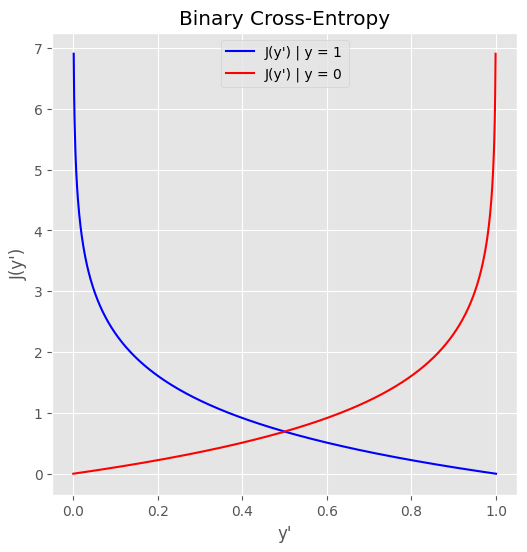

In [28]:
# cross entropy plot y =1 
plt.rcParams["figure.figsize"] = (6, 6)
x = torch.linspace(0, 1, 1000)
y1 = -torch.log(x)
y0 = -torch.log(1-x)

plt.figure
plt.plot(x, y1, color='b', label="J(y') | y = 1")
plt.plot(x, y0, color='r', label="J(y') | y = 0")
plt.xlabel("y'")
plt.ylabel("J(y')")
plt.legend(loc='upper center')
plt.title('Binary Cross-Entropy')
plt.show()

Let's say a data point belongs to class `1` <font style="color:blue">( Blue Curve )</font>. If the output of the network is close to `0`, then from the above diagram we can see that the loss will be very high ( The blue curve goes to infinity ). Conversely, the loss is `0` if the output of the network is `1`.

The same logic goes for the <font style="color:red">red curve</font>.

Thus, this loss function accurately captures the binary classification error - i.e. the error is high when the predicted output is different from the ground truth and vice-versa. Thus, it is the correct loss function for solving a binary classification problem.

## <font style="color:rgb(8,133,37)">Implementing Binary Cross-Entropy</font>
Now that we know why we are using Binary Cross Entropy loss, lets implement the loss and also its gradient function

**Binary cross-entropy:**
$$
J(y') = -y\log(y') - (1-y)\log(1-y')
$$

**Derivative of binary cross-entropy w.r.t its input $y'$.**
$$
\frac{\partial J}{\partial y'} = -\frac{y}{y'} + \frac{1-y}{1-y'}
$$


In [24]:
# Binary cross-entropy
def bce_loss(sigmoid_pred, g_truth):
    loss = - (1 - g_truth)* torch.log(1 - sigmoid_pred) - g_truth * torch.log(sigmoid_pred)
    return loss

# Derivative of binary cross-entropy w.r.t its input.
def grad_bce_loss(sigmoid_pred, g_truth):
    return - (g_truth * (1 / sigmoid_pred)) + ((1 - g_truth) * (1 / (1 - sigmoid_pred)))

## <font style="color:blue">7. Graph Implementation</font>
Next, We will implement the network graph, forward pass and backward pass. **We find the gradients of the parameters $w_1$, $w_2$ and $b$, using the chain rule:** Thus, we compute the gradients for each node and multiply them to get the final gradients of the loss function with respect to the weights. 

\begin{align}
\frac{\partial J}{\partial w_1} &= \frac{\partial J}{\partial y^{'}}.\frac{\partial y^{'}}{\partial z}. \frac{\partial z}{\partial w_1}  \\
\frac{\partial J}{\partial w_2} &= \frac{\partial J}{\partial y^{'}}.\frac{\partial y^{'}}{\partial z}. \frac{\partial z}{\partial w_2}  \\
\frac{\partial J}{\partial b} &= \frac{\partial J}{\partial y^{'}}.\frac{\partial y^{'}}{\partial z}. \frac{\partial z}{\partial b}  \\
\end{align}

In [29]:
class BinaryClassifierGraph:
    def __init__(self):
        """
        It is initializing the variable that will be updated in `forward` and `loss` function. 
        Storing these values will be used in `backward` function to get the gradient.
        """
        
        # default gardient is zero
        self.w0_grad = 0
        self.w1_grad = 0
        self.b_grad = 0
        
        self.x_in = None
        self.wx_plus_b_out = None
        self.sigmoid_out = None
        
        self.bce_loss = None
        
        self.grad_bce_loss = None
        
        self.g_truth = None
        
    def forward(self, w, x, b):
        # updated input value, it will be used in backward pass
        self.x_in = x
        self.b_in = b
        self.w_in = w
        
        # Intermediate node with the weighted sum
        self.wx_plus_b_out = wx_plus_b(w, x, b)
        
        # Output node after applying activation function
        self.sigmoid_out = sigmoid(self.wx_plus_b_out)
            
        return self.sigmoid_out
    
    def loss(self, g_truth):
        
        self.g_truth = g_truth
        
        # Compute the binary cross entropy loss
        self.bce_loss = bce_loss(self.sigmoid_out, g_truth)
        return self.bce_loss.mean()
    
    def backward(self):
        # Compute the gradients of Loss w.r.t neuron output (y')
        d_bce_loss = grad_bce_loss(self.sigmoid_out, self.g_truth)
        
        # Compute the gradients of neuron output(y') w.r.t weighted sum(z)
        d_sigmoid = grad_sigmoid(self.wx_plus_b_out)
        
        # Compute the gradients of weighted sum(z) w.r.t weights and bias
        d_w, d_b = grad_wx_plus_b(self.x_in)
        
        # Using chain rule to find overall gradient of Loss w.r.t weights and bias
        self.w0_grad = d_bce_loss * d_sigmoid * d_w[:,0]
        self.w1_grad = d_bce_loss * d_sigmoid * d_w[:,1]
        self.b_grad = d_bce_loss * d_sigmoid * d_b
        
        return
    
    def gradients(self):
        
        w_grad = torch.tensor([[self.w0_grad.mean()], [self.w1_grad.mean()]])
        b_grad = torch.tensor([self.b_grad.mean()])
        
        return w_grad, b_grad
        


## <font style="color:blue">8. Update Parameters</font>

This is the gradient descent update step which we are already familiar with from previous week! Just to recap, we take the gradients and update the weights and biases. We use a scaling factor called the **Learning rate**.

In [30]:
def gradient_descent_update(w, b, dw, db, lr):
    w = w - lr * dw
    b = b - lr * db
    
    return w, b

## <font style="color:blue">9. Training Loop</font>

Training loop is running for the given number of epochs where we do the following:

1. Divide the data into batches
1. For each batch, we compute the activations using the `forward` pass.
1. Compute the loss using Binary Cross Entropy
1. Compute the gradients using the backward function.
1. Finally, update gradient using `gradient_descent_update` function.

We keep track of the loss for each batch.

In [32]:
import time
def train(w, b, data_points, label, epochs=100, lr=0.01, batch_size=10):
    
    bc = BinaryClassifierGraph()
    
    # for storing loss of each batch
    avg_train_loss = np.array([])
    
    updated_parms = []
    for epoch in range(epochs):
        
        # for storing loss of each batch in current epoch
        avg_loss = np.array([])
        
        num_baches = int(len(label)/batch_size)
        
        # Shuffle data and label # This is important to avoid bias in training 
        shuffled_index = random.sample(range(len(label)), len(label))  
        s_data_points = data_points[shuffled_index]
        s_label = label[shuffled_index]
        
        print('\nEpoch: {}'.format(epoch+1))
        
        for batch_idx in range(num_baches):
            # get training data in batch
            start_index = batch_idx * batch_size
            end_index = (batch_idx + 1) * batch_size
            data = s_data_points[start_index:end_index]
            g_truth = s_label[start_index:end_index]
            
            # forward pass
            bc.forward(w, data, b)
            
            # Find loss
            loss = bc.loss(g_truth)
            
            # Backward will find gradient using chain rule 
            bc.backward()
            
            # Get gradients after they are updated using the backward function
            grad_w, grad_b = bc.gradients()
            
            # Update parameters using gradient descent
            w, b = gradient_descent_update(w, b, grad_w, grad_b, lr)
                
            # to show training results
            avg_loss = np.append(avg_loss, [loss])
            avg_train_loss = np.append(avg_train_loss, [loss])
            time.sleep(0.001)
            print("\rBatch: {0}/{1} | Avg Batch Loss: {2:.3} | Batch Loss: {3:.3} | Avg Train Loss:{4:.3}".
                  format(batch_idx+1, num_baches, avg_loss.mean(), loss.item(), avg_train_loss.mean()), end="")
    
        # storing parameters to show decision boundary animition
        updated_parms.append((w.data[0][0].clone(), w.data[1][0].clone(), b.data[0].clone()))
            
    return w, b, avg_train_loss, updated_parms



# <font style="color:blue">10. Start Training</font>

We initialize the parameters with random weights and start training

In [44]:
input_size = 2
w = torch.randn(input_size, 1)
b = torch.zeros(1)

w, b, avg_train_loss, updated_parms= train(w, b, data_points, label)
print('\nw:\n{}'.format(w))
print('\nb:\n{}'.format(b))


Epoch: 1
Batch: 100/100 | Avg Batch Loss: 1.25 | Batch Loss: 0.717 | Avg Train Loss:1.25
Epoch: 2
Batch: 100/100 | Avg Batch Loss: 0.58 | Batch Loss: 0.546 | Avg Train Loss:0.913
Epoch: 3
Batch: 100/100 | Avg Batch Loss: 0.556 | Batch Loss: 0.483 | Avg Train Loss:0.794
Epoch: 4
Batch: 100/100 | Avg Batch Loss: 0.54 | Batch Loss: 0.498 | Avg Train Loss:0.731
Epoch: 5
Batch: 100/100 | Avg Batch Loss: 0.524 | Batch Loss: 0.415 | Avg Train Loss:0.689
Epoch: 6
Batch: 100/100 | Avg Batch Loss: 0.51 | Batch Loss: 0.463 | Avg Train Loss:0.659
Epoch: 7
Batch: 100/100 | Avg Batch Loss: 0.496 | Batch Loss: 0.583 | Avg Train Loss:0.636
Epoch: 8
Batch: 100/100 | Avg Batch Loss: 0.482 | Batch Loss: 0.493 | Avg Train Loss:0.617
Epoch: 9
Batch: 100/100 | Avg Batch Loss: 0.47 | Batch Loss: 0.501 | Avg Train Loss:0.611
Epoch: 10
Batch: 100/100 | Avg Batch Loss: 0.458 | Batch Loss: 0.372 | Avg Train Loss:0.586
Epoch: 11
Batch: 100/100 | Avg Batch Loss: 0.447 | Batch Loss: 0.533 | Avg Train Loss:0.574
Ep

# <font style="color:blue">11. Plot the Decision Boundary</font>
We will plot the decision boundary using the weight and biases obtained from training the network.

Text(0, 0.5, 'x2')

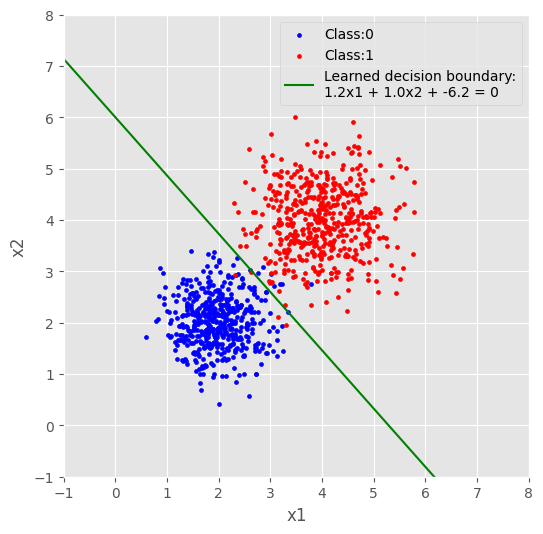

In [45]:
plt.scatter(class_zero_points[:,0], class_zero_points[:,1], s=8, color='b', label='Class:0')
plt.scatter(class_one_points[:,0], class_one_points[:,1], s=8, color='r', label='Class:1')
x1 = torch.linspace(-1, 8, 1000)
x2 = -(b.data[0] + w.data[0][0] * x1)/ w.data[1][0]
plt.plot(x1, x2, c='g', label='Learned decision boundary:\n{0:.2}x1 + {1:.2}x2 + {2:.2} = 0'.
         format(w.data[0][0], w.data[1][0], b.data[0]))
plt.legend()
plt.xlim([-1, 8])
plt.ylim([-1, 8])
plt.xlabel('x1')
plt.ylabel('x2')

# <font style="color:blue">12. Plot the Loss Curve</font>

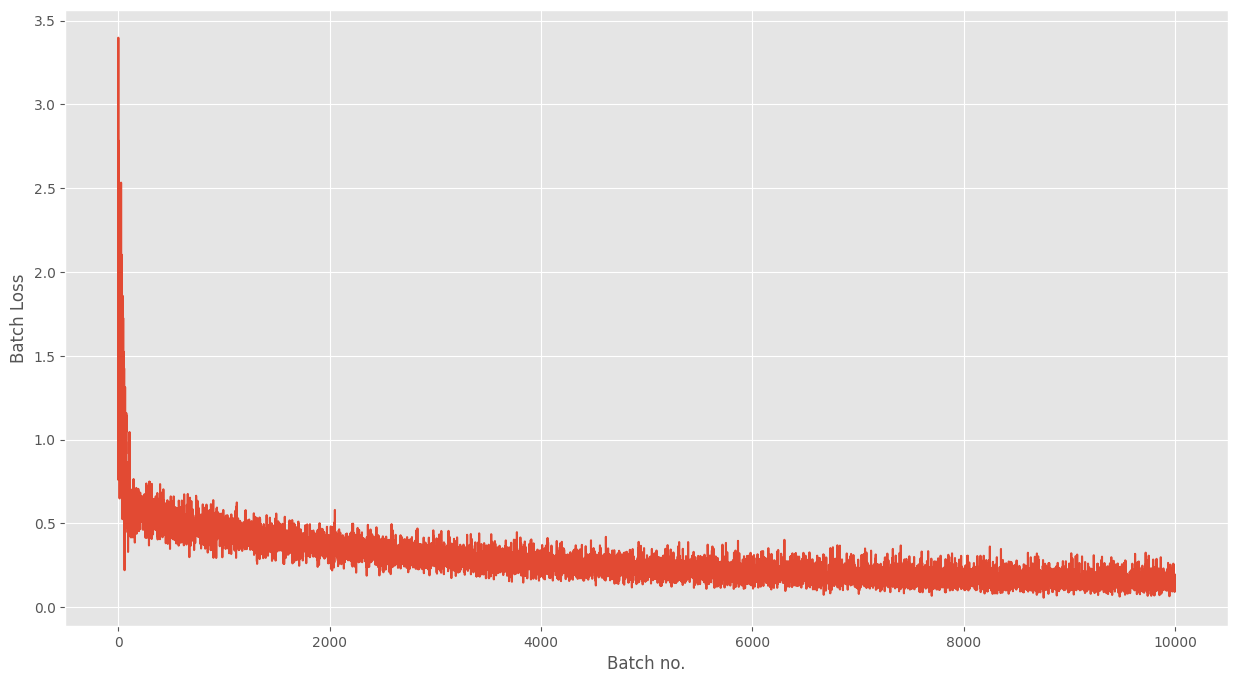

In [46]:
plt.rcParams["figure.figsize"] = (15, 8)
plt.figure
plt.plot(range(len(avg_train_loss)), avg_train_loss)
plt.xlabel('Batch no.')
plt.ylabel('Batch Loss')
plt.show()

# <font style="color:blue">13. Accuracy</font>

In [47]:
def accuracy(w, b, inputs, label):
    bc = BinaryClassifierGraph()
    prediction = bc.forward(w, inputs, b)
    pred = prediction >= 0.5
    pred = pred.squeeze()
    label = label.type(torch.bool)
    count = len(label)
    
    correct_pred = torch.sum(torch.eq(pred, label))
    accuracy = correct_pred * 1.0/count
    return accuracy

In [48]:
accuracy(w, b, data_points, label)

tensor(0.9890)

# <font style="color:blue">14. Decision Boundary Animation</font>
We have saved the weights at the end of each epoch. So, we can plot them and see how the weights got updated and how decision boundary changed before it converged.

In [49]:
%matplotlib notebook

plt.rcParams["figure.figsize"] = (10, 10)

fig, ax = plt.subplots()

ax.set_xlim(-1, 8)
ax.set_ylim(-1, 8)
ax.set_xlabel('x1')
ax.set_ylabel('x2')

line, = ax.plot(0, 0, color='g', label='Decision Boundary')
ax.scatter(class_zero_points[:,0], class_zero_points[:,1], s=8, color='b', label='Class:0')
ax.scatter(class_one_points[:,0], class_one_points[:,1], s=8, color='r', label='Class:1')
ax.legend(loc='upper right')

def plot_points_line(parm, line):
    x1 = torch.linspace(-1, 8, 1000)
    x2 = -(parm[2] + parm[0] * x1)/ parm[1]
    line.set_xdata(x1)
    line.set_ydata(x2)
    
    return line, 
    

line_animation = animation.FuncAnimation(fig, func=plot_points_line, frames=updated_parms, fargs=(line,),
                                         interval=200)
plt.show()

<IPython.core.display.Javascript object>

## <font style="color:rgb(8,133,37)">Exercise</font>

1. Try to use MSE loss and see if it converges to an optimal solution. If not, find the reason. Check if the vanishing gradient is the culprit.

2. Instead of using the chain rule, derive the gradient function of the whole graph, and try using this for gradient update. For deriving the gradient function, you can use the chain rule.